## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
#import modules, which consist of python command
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp

/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#load extensions
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
import pickle
pickle_in = open("pickled_0.080_gamma","rb")
syn = pickle.load(pickle_in)

In [6]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [7]:
times, counts = getLineage("DoupeAggregate.tsv")

In [8]:
from mpmath import *
import cmath

import math
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [9]:
def F(x, y, t, r, gamma):
#     v = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5)
    v = (1 - 4 * r)** 0.5    
#     w = (gamma * (1 - 2 * r) - 2 * r) / scipy.linalg.fractional_matrix_power(
#         2 * gamma * (1 - 4 * r), 0.5)
    w = (gamma * (1 - 2 * r) - 2 * r) / (2 * gamma * (1 - 4 * r)** 0.5)    
#     gg = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5) / gamma
    gg = (1 - 4 * r)** 0.5 / gamma
    u = (1 - y) * np.exp(-gamma * t)
    u0 = (1 - y)
    Q = 1 + 2 * w - gg * u0 + (2 * r * (x - y) + y - 1) / gamma
    C = (-Q * whitm(w, 0, gg * u0) + (1 + 2 * w) * whitm(1 + w, 0, gg * u0)) / \
        (Q * whitw(w, 0, gg * u0) + 2 * whitw(1 + w, 0, gg * u0))
    f = 1 - u + \
        (u * (1 + v) - gamma * (1 + 2 * w)) / (2 * r) + \
        (gamma / (2 * r)) * ((1 + 2 * w) * whitm(1 + w, 0, u * gg) -
                             2 * C * whitw(1 + w, 0, u * gg)) / \
        (whitm(w, 0, u * gg) + C * whitw(w, 0, u * gg))
    return f


def Antal(z, t, r, gamma):
    g = []
    for k in range(len(z)):
        if z[k] == 1:
            g.append(1)
        else:
            g.append(F(z[k], z[k], t, r, gamma))
            
#     for k in range(1, len(z) + 1):
#         if z[k] == 1:
#             g[k] = 1
#         else:
#             g[k] = F(z[k], z[k], t, r, gamma)

    return g

In [10]:
def Psurv(t, l, r, rho):
    rho = rho - 0.00001
    gamma = rho / (1 - rho)
    T = l * t
    p = 1 - np.real(Antal([0], T, r, gamma))
#     if (p <= 0 or p > 1 or np.isnan(p)):
    if (p <= 0 or p > 1):
        p = Psurv(t, l, r + 0.00001, rho - 0.001)
    return p

In [11]:
def Pn(n, t, l, r, rho, N, returnConsecutive='', max_n=''):
    if max(n) >= N:
        N = max(n) + 1
    rho = rho - 0.00001
    assert (rho < 1)
    assert (rho > 0)
    gamma = rho / (1 - rho)
    T = l * t
#     k = range(N)
#     Gvals = Antal(cmath.exp(2 * np.pi * 1j * k / N), T, r, gamma)
    Gvals = Antal([cmath.exp(2 * np.pi * 1j * k / N) for k in range(int(N))], T, r, gamma)
    p = []

    if returnConsecutive:
        p = np.zeros(max_n)
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#              p[n[lp]] = \
#                 np.real((1 / N) *
#                         sum(Gvals * np.exp(-2 * np.pi * 1j * k * n[lp] / N)))
            temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[n[lp]-1] = np.real((1 / N) *sum([a*b for a,b in zip(Gvals,temporary)]))
                               
    else:
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#             p[lp] = \
#                 np.real((1 / N) * sum(Gvals *
#                                       np.exp(-2 * np.pi * 1j * k * n[lp] / N)))          
            Temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[lp] = np.real((1 / N) * sum(a*b for a,b in zip(Gvals,Temporary)))
#     print(Gvals)
    tst = sum(p)
    print(tst)
    if (tst > 1 or tst < 0 or np.isnan(tst)):
        print('Pathological point: r=' + str(r) + ' rho=' + str(
            rho) + '. Making 0.1% perturbation')
        p = Pn(n, t, l, r + 0.00001, rho - 0.001, N, returnConsecutive, max_n)

#     for x in range(len(p)):
#         if (p[x] < 0):
#             p[x] = 0

#     p[p < 0 & p > -1e-5] = 0

    return(p)

In [12]:
def logLikelihood(obs,lpBins,binSize):
    maxClone = len(lpBins)
    def noisyMul(a,b,i):
        #print("logP",lp, "\nobsv", obs); lp[i]*obs[i]
        print("logP",a, "\nobsv", b)
        return(a[i]*b[i])
    obsBins = [sum(obs[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))]
    return(sum([obsBins[j]*lpBins[j] for j in range(maxClone)]))

def allLogLike(obs,lpBins,binSize):
    return(sum([logLikelihood(o,p,binSize) for o,p in zip(obs,lpBins)]))

def logProbability(probability,binSize):
    binSizeList = [[sum(t[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))] for t in probability]
    logFreq = [[0 if n<=0 else math.log10(n) for n in t] for t in binSizeList]
    return(logFreq)

def calculateLikelihood(probability,binSize,data):
    lpBins = logProbability(probability, binSize)
    like = allLogLike(data,lpBins,binSize)
    #print(like)
    return(like)

In [13]:
def main(t,nRange,lambdaRange,rhoRange,rRange,binSize,data):
    maxN = max(list(map(max, nRange)))
    
#     PScanPP = np.zeros(len(lambdaRange), len(rhoRange), len(rRange),
#                        len(nRange), maxN)    
    PScanPP = [[[[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))] for L2 in range(len(rhoRange))] for L1 in range(len(lambdaRange))]
    
#     PSurvScanPP = np.zeros(len(lambdaRange), len(rhoRange), len(rRange),
#                            len(nRange))    
    PSurvScanPP = [[[np.zeros(len(nRange)) for L3 in range(len(rRange))] for L2 in range(len(rhoRange))] for L1 in range(len(lambdaRange))]

    timePoints = range(len(t))
    nBadValues = 0

    for L1 in range(len(lambdaRange)):       
        PScanPP_local = [[[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))] for L2 in range(len(rhoRange))]
             
        PSurvScanPP_local = [[np.zeros(len(nRange)) for L3 in range(len(rRange))] for L2 in range(len(rhoRange))]

        for L2 in range(len(rhoRange)):
            for L3 in range(len(rRange)):
                for L4 in timePoints:
                    probS = Psurv(t[L4], lambdaRange[L1], rRange[L3], rhoRange[L2])
                    avgN = 1 / probS
                    Niter = max([normal_round(int(4*avgN)), normal_round(1.5*max(nRange[L4])), 10])
                    probN = Pn(nRange[L4], t[L4], lambdaRange[L1], rRange[L3],
                               rhoRange[L2], Niter, 'returnConsecutive', maxN)

                    if any(probN > 1) or \
                            sum(probN) > 1 or \
                            probS > 1 or \
                            probS <0 or \
                            abs(probS-sum(probN))>1e-3:
                        print('Bad values at time t=' + str(t[L4]) + ' lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
                        print('any(probN>1=' + str(any(probN>1)) + ', sum(probN)>1=' + str(sum(probN)>1) + ', (probS-sum(probN))=' + str(probS-sum(probN)))
                        nBadValues += 1
                    else:
                        print('Completed time t=' + str(t[L4]) + ' weeks, lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rhoRange[L2]) + ' r=' + str(rRange[L3]))
    
#                     PSurvScanPP_local[L2][L3][L4] = probS
                    PScanPP_local[L2][L3][L4][:] = probN/probS
                PScanPP_local[L2][L3] = calculateLikelihood(PScanPP_local[L2][L3],binSize,data)
        PSurvScanPP[L1] = PSurvScanPP_local
        PScanPP[L1] = PScanPP_local

    return(PScanPP) 

In [14]:
nSize = len(np.transpose(counts))
nBin = int(round(np.log(nSize)/np.log(2)+0.5))
binSize = np.append([1],[2**(n-1) for n in range(1,(nBin+1))])


In [15]:
t = times/7
nRange = [list(range(1, max(np.where(t>0)[0])+1)) for t in syn]
lambdaRange = [2.9]
bins=20
rhoRange = [(i*0.8/bins) for i in range(1,bins)]
rRange = [(i*0.2/bins) for i in range(1,bins)]


In [16]:
%time result = main(t,nRange,lambdaRange,rhoRange,rRange,binSize,syn)

0.8770582953053068
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.04 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12293359161851614')]
0.9775368630361957
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022286309255118986')]
0.9812676415442886
Bad values at time t=3.0 lambda=2.9 rho=0.04 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017765286474517805')]
0.971983205027438
Bad values at time t=6.0 lambda=2.9 rho=0.04 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023706075713481045')]
0.9448944953726264
Bad values at time t=12.0 lambda=2.9 rho=0.04 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036300880699481786')]
0.882509046425953
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018206364421152199')]
0.

0.22329297275257878
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024686715952899257')]
0.8768426014341881
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12309259301406028')]
0.94585988116259
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.052742631805836826')]
0.9211258932424764
Bad values at time t=3.0 lambda=2.9 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.071418084152134576')]
0.8781402514761231
Bad values at time t=6.0 lambda=2.9 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.090533656929749129')]
0.7995130743544746
Bad values at time t=12.0 lambda=2.9 rho=0.04 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0831972836993079')]
0.5

0.47001982874235887
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.04 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033104828562915023')]
0.14993155498209249
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.04 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015669093403563317')]
0.8760659177596575
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.04 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12381275697899574')]
0.9282630731359757
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.04 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.069147937281954452')]
0.8994647178129447
Bad values at time t=3.0 lambda=2.9 rho=0.04 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.087040367487921433')]
0.8563249842315652
Bad values at time t=6.0 lambda=2.9 rho=0.04 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.089755

0.3054605618029349
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048251414732880527')]
0.8836883357347155
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.08 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11620913002640021')]
0.9732472748227875
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.08 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024610837878290215')]
0.9655815038530162
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023122316615501015')]
0.9267174444913018
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025479936854554408')]
0.7892523896027128
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.030000000000000006
any(pro

0.23928712503468438
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.08 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02765122071713369')]
0.08241388493871271
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014515153627932098')]
0.8821704802106809
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.08 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11748881268183764')]
0.9443407807978179
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.08 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.048694759713077573')]
0.906881018901038
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.058206851200220178')]
0.805248467683728
Bad values at time t=6.0 lambda=2.9 rho=0.08 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0637767845355

0.48436127964988407
Bad values at time t=12.0 lambda=2.9 rho=0.08 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046854182694114566')]
0.1644225510975502
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.08 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022281047736322585')]
0.0484877764536223
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.08 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010950206038389851')]
0.8802466627324153
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.08 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11917594866520975')]
0.9254326096845618
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.08 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.063010384359516447')]
0.8726914982751581
Bad values at time t=3.0 lambda=2.9 rho=0.08 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.071935

0.8590002308377742
Bad values at time t=6.0 lambda=2.9 rho=0.12000000000000002 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016544775438916082')]
0.6192122055999698
Bad values at time t=12.0 lambda=2.9 rho=0.12000000000000002 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018113027359086376')]
0.31832171319617775
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.12000000000000002 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0092058881740244569')]
0.15789688010328756
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.12000000000000002 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.005593070306242176')]
0.8896462158189504
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.12000000000000002 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10994891313075494')]
0.96668335173046
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.1200000

0.06378814006519085
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.12000000000000002 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010216917825636163')]
0.8871833329084714
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.12000000000000002 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11192965453343129')]
0.9403711549451927
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.12000000000000002 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.042556648039066891')]
0.8749470143930999
Bad values at time t=3.0 lambda=2.9 rho=0.12000000000000002 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045620062906663761')]
0.6952151587458878
Bad values at time t=6.0 lambda=2.9 rho=0.12000000000000002 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045637513461166068')]
0.3833327784542457
Bad va

0.8295653523444646
Bad values at time t=3.0 lambda=2.9 rho=0.12000000000000002 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.057874128943101733')]
0.6151072639520194
Bad values at time t=6.0 lambda=2.9 rho=0.12000000000000002 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.052048164891752569')]
0.30256487146744465
Bad values at time t=12.0 lambda=2.9 rho=0.12000000000000002 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.035694681711088416')]
0.0955797254652997
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.12000000000000002 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017153034437644918')]
0.03699068707673544
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.12000000000000002 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0087287762691190887')]
0.8840881302394421
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.12000000000000002 r

0.76517137053956
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011555891238429927')]
0.48672424229512296
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012293573563116056')]
0.2457032377813454
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061337530615400704')]
0.12441311933351466
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0037441164096879281')]
0.8954134623551113
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.16 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10367635927181307')]
0.9609125176766449
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.16 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (p

0.8254737120561486
Bad values at time t=3.0 lambda=2.9 rho=0.16 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036171150543575781')]
0.5810399931949505
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033708894016832858')]
0.28136423898766705
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027527294531609847')]
0.11212070744563576
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014049306384500831')]
0.05073069217972745
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0076712533029429653')]
0.8910846982293128
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.16 r=0.13
any(prob

0.48088009910533247
Bad values at time t=6.0 lambda=2.9 rho=0.16 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.041261896204524917')]
0.2026054158161173
Bad values at time t=12.0 lambda=2.9 rho=0.16 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028008811898363628')]
0.07177104549728622
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.16 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013572757829138665')]
0.031020832723446974
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.16 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0070325051834976768')]
0.9058471558600859
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.2 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.093901143330719861')]
0.9914381503663677
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.2 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003

0.8403904283077652
Bad values at time t=3.0 lambda=2.9 rho=0.2 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016505370061933533')]
0.6029771585618796
Bad values at time t=6.0 lambda=2.9 rho=0.2 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014186775273765551')]
0.3295890047577255
Bad values at time t=12.0 lambda=2.9 rho=0.2 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014128318032197662')]
0.156999839165461
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.2 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0073149627011321883')]
0.07750299395267683
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.2 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0043481085955658499')]
0.8989979834242134
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.2 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.098759021507221378')]
0.9

0.9029755437239225
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.2 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036273865928350246')]
0.7396738850791045
Bad values at time t=3.0 lambda=2.9 rho=0.2 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033064980860151971')]
0.4509025034569237
Bad values at time t=6.0 lambda=2.9 rho=0.2 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028679528712204749')]
0.20271444985398004
Bad values at time t=12.0 lambda=2.9 rho=0.2 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022335543845933808')]
0.08492680679085236
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.2 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011279099823068892')]
0.039540931979001735
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.2 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061403648060016983')]
0

0.3318794664802358
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.24000000000000005 r=0.030000000000000006
0.18820515829312257
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.24000000000000005 r=0.030000000000000006
0.9098770278865679
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.24000000000000005 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.088596583767795445')]
0.9660908551872651
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.24000000000000005 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0083644587988584984')]
0.8909663708647902
Bad values at time t=3.0 lambda=2.9 rho=0.24000000000000005 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032186240039376868')]
0.7109688433971235
Bad values at time t=6.0 lambda=2.9 rho=0.24000000000000005 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015985446185564633')]
0.4774470206652332
Bad values

0.4965129124171218
Bad values at time t=6.0 lambda=2.9 rho=0.24000000000000005 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012891978742674004')]
0.26078481057397346
Bad values at time t=12.0 lambda=2.9 rho=0.24000000000000005 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012474392583919747')]
0.12451456569303009
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.24000000000000005 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0064442014854111523')]
0.06155711694564462
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.24000000000000005 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0038011771020140736')]
0.9020711553059901
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.24000000000000005 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.093775966566941538')]
0.9122258620786086
Bad values at time t=1.4285714285714286 lambda=2

0.07752638614410906
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.24000000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0091566222499067096')]
0.03696815839138586
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.24000000000000005 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0050501606518962641')]
0.89563222018441
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.24000000000000005 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.098007705625676289')]
0.872159636705794
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.24000000000000005 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033487955753624954')]
0.659956156653721
Bad values at time t=3.0 lambda=2.9 rho=0.24000000000000005 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028703096793417093')]
0.36657332581952434
Bad values at time t=6.0 lambda=2.9 rho=0.2400000

0.22488512108736594
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.28 r=0.05
0.12057129784422364
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.28 r=0.05
0.9135583280282311
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.28 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.083158352981289818')]
0.9407843848388641
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.28 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0092302983988180598')]
0.8141732552302346
Bad values at time t=3.0 lambda=2.9 rho=0.28 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004144759919820884')]
0.5885297144925445
Bad values at time t=6.0 lambda=2.9 rho=0.28 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025408754278224421')]
0.36339134775037724
Bad values at time t=12.0 lambda=2.9 rho=0.28 r=0.06000000000000001
any

0.10309604709107276
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.28 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0057286807353912617')]
0.0510283126246339
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.28 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0033602136622020926')]
0.9038241223456193
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.28 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.089152938438337936')]
0.8793827032924705
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.28 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021545488001854518')]
0.6698020996956962
Bad values at time t=3.0 lambda=2.9 rho=0.28 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016010234243620136')]
0.3951039449255904
Bad values at time t=6.0 lambda=2.9 rho=0.28 r=0.13
any(probN>1=False, sum(probN)>1=False, (

0.06406809581838753
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.28 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0079075223886268392')]
0.03079727726338505
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.28 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0043450215797510815')]
0.9283647602741375
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.32 r=0.01
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.070871142568470824')]
0.9876813216560988
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.32 r=0.01
0.9560457414411582
Completed time t=3.0 weeks, lambda=2.9 rho=0.32 r=0.01
0.8851048058198238
Completed time t=6.0 weeks, lambda=2.9 rho=0.32 r=0.01
0.7670521047413554
Completed time t=12.0 weeks, lambda=2.9 rho=0.32 r=0.01
0.587749023123919
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.32 r=0.01
0.40521346727763874
Completed time t=52.142857142857146 weeks, lambda=2.9

0.2653805309746368
Bad values at time t=12.0 lambda=2.9 rho=0.32 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048179223399159032')]
0.13496708238470856
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.32 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0023878186362010778')]
0.0690409625909106
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014895181319306977')]
0.9123753107884737
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.32 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.080132957829826101')]
0.8874888027159991
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.32 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012641621690450577')]
0.688919680386722
Bad values at time t=3.0 lambda=2.9 rho=0.32 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.007397

0.32265368087466223
Bad values at time t=6.0 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013063154845401936')]
0.16224307361388343
Bad values at time t=12.0 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011444237091026183')]
0.07663869939954737
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.005863451464420133')]
0.0376550095531003
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.32 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0033559041224311484')]
0.9008026523858158
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.32 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.086651836521814407')]
0.8225099171934177
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.32 r=0.17
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02

0.7624571629988919
Bad values at time t=3.0 lambda=2.9 rho=0.36 r=0.06000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014929162172976351')]
0.5483883894717538
Completed time t=6.0 weeks, lambda=2.9 rho=0.36 r=0.06000000000000001
0.3481868965991625
Completed time t=12.0 weeks, lambda=2.9 rho=0.36 r=0.06000000000000001
0.19008861603541258
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.36 r=0.06000000000000001
0.10130250568682778
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.36 r=0.06000000000000001
0.9227006127202025
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.36 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.070235624834417476')]
0.9048892355990276
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.36 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.005885775149176653')]
0.7336557383256691
Bad values at time t=3.0 lambda=2.9 rho=0.36 r=0.07
any(probN>1=Fals

0.09467779308630138
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.36 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035077673812029947')]
0.04752023151916862
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.36 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021115788381226297')]
0.908324007059784
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.36 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.077795661454610032')]
0.825322962725239
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.36 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015045295006109738')]
0.5792632755824529
Bad values at time t=3.0 lambda=2.9 rho=0.36 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0098300391032093426')]
0.33887223474363887
Bad values at time t=6.0 lambda=2.9 rho=0.36 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.007

0.895680059336032
Completed time t=3.0 weeks, lambda=2.9 rho=0.4 r=0.02
0.7755124519571607
Completed time t=6.0 weeks, lambda=2.9 rho=0.4 r=0.02
0.6107011815886796
Completed time t=12.0 weeks, lambda=2.9 rho=0.4 r=0.02
0.4110339450525031
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.4 r=0.02
0.2521593551820609
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4 r=0.02
0.9378305339194976
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.4 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.058170473283018054')]
0.9500028755403497
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4 r=0.030000000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011421145581879122')]
0.8516130924516015
Completed time t=3.0 weeks, lambda=2.9 rho=0.4 r=0.030000000000000006
0.6975505292124635
Completed time t=6.0 weeks, lambda=2.9 rho=0.4 r=0.030000000000000006
0.5113556146372599
Completed time t=12.0 weeks,

0.219348244629955
Bad values at time t=12.0 lambda=2.9 rho=0.4 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035851651575074528')]
0.11107312191840496
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017873065821975564')]
0.05670802627089128
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011248069059867569')]
0.9151002524165899
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.4 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.069319659807600242')]
0.824958385387268
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0095664555930117245')]
0.5908517222063067
Bad values at time t=3.0 lambda=2.9 rho=0.4 r=0.12

0.27271334713458306
Bad values at time t=6.0 lambda=2.9 rho=0.4 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0091230836888440692')]
0.1414004295710293
Bad values at time t=12.0 lambda=2.9 rho=0.4 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0083004063847350318')]
0.06800686915215516
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0042534883875528923')]
0.03371620138154783
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0024703696938793915')]
0.8988088368537334
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.4 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.077011216772820301')]
0.7479094673213078
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01790

0.45538505623272074
Completed time t=6.0 weeks, lambda=2.9 rho=0.44000000000000006 r=0.08
0.27807430647846104
Completed time t=12.0 weeks, lambda=2.9 rho=0.44000000000000006 r=0.08
0.14739724955989242
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.44000000000000006 r=0.08
0.07727135307639828
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.44000000000000006 r=0.08
0.9258474105212098
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.44000000000000006 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.059086713889026532')]
0.8454807247782951
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.44000000000000006 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004552921730724413')]
0.6395663824510757
Bad values at time t=3.0 lambda=2.9 rho=0.44000000000000006 r=0.09
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017509859642997894')]
0.4261946751878853
Bad values at time t=6.0 lambda=2.9 

0.30554882229269553
Bad values at time t=6.0 lambda=2.9 rho=0.44000000000000006 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048588458657549127')]
0.16641515403769921
Bad values at time t=12.0 lambda=2.9 rho=0.44000000000000006 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0050656583733630633')]
0.08217404042658442
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.44000000000000006 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025913295497620031')]
0.04135355008268834
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.44000000000000006 r=0.15
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015765142341285579')]
0.9060714851655671
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.44000000000000006 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.06775312250922938')]
0.7538317111560744
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.

0.9159231786301917
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.4800000000000001 r=0.04
0.788753721498173
Completed time t=3.0 weeks, lambda=2.9 rho=0.4800000000000001 r=0.04
0.6189791713474426
Completed time t=6.0 weeks, lambda=2.9 rho=0.4800000000000001 r=0.04
0.43260182383069257
Completed time t=12.0 weeks, lambda=2.9 rho=0.4800000000000001 r=0.04
0.256251304862282
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.4800000000000001 r=0.04
0.14350993660989125
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4800000000000001 r=0.04
0.942561600777755
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.4800000000000001 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046763178476559308')]
0.8970864620702896
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4800000000000001 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010851480642324329')]
0.7493889221728358
Completed time t=3.0 weeks, la

0.10198564335317331
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4800000000000001 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011327975068048113')]
0.05219667509651069
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.4800000000000001 r=0.12000000000000002
0.9152130695300774
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.4800000000000001 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.057853406740500435')]
0.7696143046742572
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.4800000000000001 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0064120078655145463')]
0.5347516712136332
Bad values at time t=3.0 lambda=2.9 rho=0.4800000000000001 r=0.13
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032471969651693966')]
0.33216044687690754
Bad values at time t=6.0 lambda=2.9 rho=0.4800000000000001 r=0.13
any(probN>1=False, sum(probN)>1=False,

0.4378325401386365
Bad values at time t=3.0 lambda=2.9 rho=0.4800000000000001 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0076727345400209312')]
0.25058307376317096
Bad values at time t=6.0 lambda=2.9 rho=0.4800000000000001 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0060872143121878941')]
0.13295476220012217
Bad values at time t=12.0 lambda=2.9 rho=0.4800000000000001 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0058946455926755792')]
0.06473177013674361
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.4800000000000001 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0030252482951002857')]
0.03231152038782948
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.4800000000000001 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017940057490328717')]
0.963570854072823
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.52 r=0.01
any(probN

0.06241961901956816
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.52 r=0.1
0.92276568138873
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.52 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.048851468569757528')]
0.7806210627192066
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.52 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035211529772124495')]
0.5641388168207122
Bad values at time t=3.0 lambda=2.9 rho=0.52 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001416633053230143')]
0.3660185113874617
Completed time t=6.0 weeks, lambda=2.9 rho=0.52 r=0.11000000000000001
0.2143196760399403
Bad values at time t=12.0 lambda=2.9 rho=0.52 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012430628462193338')]
0.11034474021528465
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.52 r=0.1100000

0.25796994970342274
Bad values at time t=6.0 lambda=2.9 rho=0.52 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.004204669791142146')]
0.13957997137088976
Bad values at time t=12.0 lambda=2.9 rho=0.52 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0043825638483029061')]
0.06864716026388781
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.52 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0022491379217175755')]
0.034474759785909206
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.52 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001366476748128051')]
0.8931293008682408
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.52 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.059434072908059354')]
0.6715078888405664
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.52 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0

0.7817923607393498
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.56 r=0.1
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.00208887316491424')]
0.5778750152638585
Completed time t=3.0 weeks, lambda=2.9 rho=0.56 r=0.1
0.3844321972010449
Completed time t=6.0 weeks, lambda=2.9 rho=0.56 r=0.1
0.22990471950879407
Completed time t=12.0 weeks, lambda=2.9 rho=0.56 r=0.1
0.11998570535866401
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.56 r=0.1
0.06239370308943627
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.56 r=0.1
0.922743532423139
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.56 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.042652740354078844')]
0.7649912741315873
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.56 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025725800302854873')]
0.5543743260507665
Completed time t=3.0 weeks, lam

0.2551569679766965
Bad values at time t=6.0 lambda=2.9 rho=0.56 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032284509911129078')]
0.13929121414176202
Bad values at time t=12.0 lambda=2.9 rho=0.56 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035213013309932928')]
0.06880990813736483
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.56 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018063515033922978')]
0.03465576262045586
Bad values at time t=52.142857142857146 lambda=2.9 rho=0.56 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011137629254675263')]
0.8888134216166517
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.56 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.053570372798374954')]
0.6514327281581161
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.56 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0

0.5700503456599856
Completed time t=3.0 weeks, lambda=2.9 rho=0.6 r=0.1
0.38099771592798504
Completed time t=6.0 weeks, lambda=2.9 rho=0.6 r=0.1
0.22880908212029363
Completed time t=12.0 weeks, lambda=2.9 rho=0.6 r=0.1
0.11972538881051084
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.6 r=0.1
0.06235894344984115
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6 r=0.1
0.9216822727695613
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.6 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036679714359563853')]
0.7513733068803192
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.6 r=0.11000000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018564001013798848')]
0.5464746863402161
Completed time t=3.0 weeks, lambda=2.9 rho=0.6 r=0.11000000000000001
0.35868337138645584
Completed time t=6.0 weeks, lambda=2.9 rho=0.6 r=0.11000000000000001
0.2122214975263397
Completed time t=12.0 weeks, la

0.034805662981942986
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.6 r=0.18
0.8831711326432626
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.6 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.047775987910655959')]
0.6343351439460778
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.6 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061965316616441335')]
0.40883427083568524
Bad values at time t=3.0 lambda=2.9 rho=0.6 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0035970707595794904')]
0.24237250007594266
Bad values at time t=6.0 lambda=2.9 rho=0.6 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028674595331257546')]
0.13226080822447073
Bad values at time t=12.0 lambda=2.9 rho=0.6 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031737672027409847')]
0.065302665326515
Bad values at time t=25.714285714285715 lambda=2.9 rho=0.6 r=0.

0.5399781398340385
Completed time t=3.0 weeks, lambda=2.9 rho=0.64 r=0.11000000000000001
0.35592257953805917
Completed time t=6.0 weeks, lambda=2.9 rho=0.64 r=0.11000000000000001
0.21138364299512427
Completed time t=12.0 weeks, lambda=2.9 rho=0.64 r=0.11000000000000001
0.1097429068407654
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.64 r=0.11000000000000001
0.05692080063027025
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.64 r=0.11000000000000001
0.9139138437720079
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.64 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03243997374378782')]
0.7224787737953264
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.64 r=0.12000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001649814687038953')]
0.518207758780078
Completed time t=3.0 weeks, lambda=2.9 rho=0.64 r=0.12000000000000002
0.3361248689149663
Completed time t=6.0 weeks, lambda=2

0.9265891250623595
Completed time t=3.0 weeks, lambda=2.9 rho=0.68 r=0.01
0.8574660019663677
Completed time t=6.0 weeks, lambda=2.9 rho=0.68 r=0.01
0.7461422599880156
Completed time t=12.0 weeks, lambda=2.9 rho=0.68 r=0.01
0.5753934326121665
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.68 r=0.01
0.3993020434197394
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.68 r=0.01
0.9758937555238152
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.68 r=0.02
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012930647247499039')]
0.936947337903416
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.68 r=0.02
0.8632438639056247
Completed time t=3.0 weeks, lambda=2.9 rho=0.68 r=0.02
0.7505134531199449
Completed time t=6.0 weeks, lambda=2.9 rho=0.68 r=0.02
0.5950889150145714
Completed time t=12.0 weeks, lambda=2.9 rho=0.68 r=0.02
0.40390173550121256
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.68 r=0.02
0.24945700282869268
Com

0.49266947194953786
Completed time t=3.0 weeks, lambda=2.9 rho=0.68 r=0.13
0.3162143775724519
Completed time t=6.0 weeks, lambda=2.9 rho=0.68 r=0.13
0.18388866336997725
Completed time t=12.0 weeks, lambda=2.9 rho=0.68 r=0.13
0.09413207304620626
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.68 r=0.13
0.04845131278020262
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.68 r=0.13
0.8977250710711951
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.68 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029864272899792765')]
0.6792615007265685
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.68 r=0.14
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017861870783266731')]
0.47402826179921564
Completed time t=3.0 weeks, lambda=2.9 rho=0.68 r=0.14
0.3002692555512003
Completed time t=6.0 weeks, lambda=2.9 rho=0.68 r=0.14
0.17280576015669435
Completed time t=12.0 weeks, lambda=2.9 rho=0.68 r=0.14
0.08788061760503962


0.8769464668712135
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.04
0.756103558060719
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.04
0.5985984776610568
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.04
0.42255263176354496
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.04
0.2526895037626244
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.72 r=0.04
0.14238644764703415
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.72 r=0.04
0.955266912163778
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.72 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012959558287442663')]
0.8507903041582185
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.72 r=0.05
0.7126755908628873
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.05
0.544022691330445
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.05
0.36925415095165703
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.05
0.21291404842110423
Com

0.0823359092548905
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.72 r=0.15
0.04213621940160209
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.72 r=0.15
0.8783375070029281
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.72 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027460141098683111')]
0.6395018706646265
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.72 r=0.16
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018931510832065346')]
0.4361329851796937
Completed time t=3.0 weeks, lambda=2.9 rho=0.72 r=0.16
0.27103282993277716
Completed time t=6.0 weeks, lambda=2.9 rho=0.72 r=0.16
0.15372179098022384
Completed time t=12.0 weeks, lambda=2.9 rho=0.72 r=0.16
0.07746354039176463
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.72 r=0.16
0.03952445950649966
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.72 r=0.16
0.8718014180618129
Bad values at time t=0.42857142857142855 lambda

0.7971866755818008
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.76 r=0.07
0.635610854774653
Completed time t=3.0 weeks, lambda=2.9 rho=0.76 r=0.07
0.458236425157003
Completed time t=6.0 weeks, lambda=2.9 rho=0.76 r=0.07
0.29408848749903627
Completed time t=12.0 weeks, lambda=2.9 rho=0.76 r=0.07
0.16169881378325704
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.76 r=0.07
0.0865841464586537
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.76 r=0.07
0.9303534153552918
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.76 r=0.08
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012893961819052779')]
0.7747256297248637
Completed time t=1.4285714285714286 weeks, lambda=2.9 rho=0.76 r=0.08
0.6041691904690553
Completed time t=3.0 weeks, lambda=2.9 rho=0.76 r=0.08
0.425322966586027
Completed time t=6.0 weeks, lambda=2.9 rho=0.76 r=0.08
0.26714030663770294
Completed time t=12.0 weeks, lambda=2.9 rho=0.76 r=0.08
0.14440186478413938
Com

0.13832595215010943
Bad values at time t=12.0 lambda=2.9 rho=0.76 r=0.18
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001129281983216518')]
0.069206591139378
Completed time t=25.714285714285715 weeks, lambda=2.9 rho=0.76 r=0.18
0.03517049841201283
Completed time t=52.142857142857146 weeks, lambda=2.9 rho=0.76 r=0.18
0.8492713995573846
Bad values at time t=0.42857142857142855 lambda=2.9 rho=0.76 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026466805319868447')]
0.5899103021758773
Bad values at time t=1.4285714285714286 lambda=2.9 rho=0.76 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0022975992635633213')]
0.39025130719789414
Bad values at time t=3.0 lambda=2.9 rho=0.76 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012220785036560766')]
0.23667136858270466
Bad values at time t=6.0 lambda=2.9 rho=0.76 r=0.19
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001002164862

In [17]:
np.shape(result)

(1, 19, 19)

In [18]:
# result[0]

In [19]:
def plotLikelihood(result):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(result,axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0,0.2,0,0.8],aspect=0.25)
#     plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.1,1,0.02,0.2],aspect=5)
    plt.colorbar()
    plt.show()

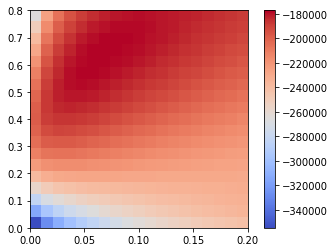

In [20]:
plotLikelihood(result[0])

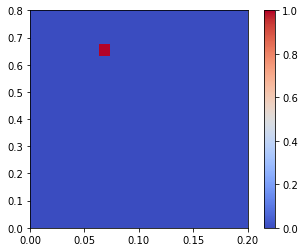

In [21]:
scaledR = result[0]-max(max(i) for i in result[0])
expR = 10**(scaledR)
plotLikelihood(expR)

In [22]:
# pickle_out = open("pickled_grid_px50","wb")
# pickle.dump(expR, pickle_out)
# pickle_out.close()

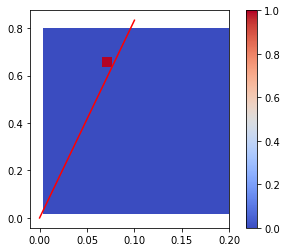

In [23]:
def plotLikelihood(result):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(result,axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.004,0.2,0.016,0.8],aspect=0.2/0.8)
#     plt.imshow((np.flip(np.transpose(result),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0.1,1,0.02,0.2],aspect=5)
    x = np.linspace(0,0.1,50)
    y = x/0.12
    plt.plot(x, y, '-r', label='y=2x+1')
    plt.colorbar()
    plt.show()

plotLikelihood(expR)

In [24]:
allSum = sum([sum(r) for r in expR])
rhoNormalised = [sum(rho) for rho in expR]/allSum
rNormalised = [sum(rho) for rho in np.transpose(expR)]/allSum
rDistribution = np.cumsum(rNormalised)
print(np.where(rDistribution>0.025))
print(np.where(rDistribution<0.975))

(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18]),)
(array([0, 1, 2, 3, 4, 5]),)


In [26]:
rRange[6]

0.07

In [27]:
rhoDistribution = np.cumsum(rhoNormalised)
print(np.where(rhoDistribution>0.025))
print(np.where(rhoDistribution<0.975))

(array([15, 16, 17, 18]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)


In [28]:
rhoRange[15]

0.64

In [29]:
rRange[6]/rhoRange[15]

0.10937500000000001

In [ ]:
0.2/15